# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# import all modules required

import idx2numpy
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.misc import imresize
import tensorflow as tf

In [2]:
# read the idx files

train_images_raw = idx2numpy.convert_from_file('./MNIST/train-images.idx3-ubyte')
train_labels_raw = idx2numpy.convert_from_file('./MNIST/train-labels.idx1-ubyte')
test_images_raw = idx2numpy.convert_from_file('./MNIST/t10k-images.idx3-ubyte')
test_labels_raw = idx2numpy.convert_from_file('./MNIST/t10k-labels.idx1-ubyte')
print "Raw training set size- ", train_images_raw.shape, train_labels_raw.shape
print "Raw testing set size- ", test_images_raw.shape, test_labels_raw.shape

Raw training set size-  (60000, 28, 28) (60000,)
Raw testing set size-  (10000, 28, 28) (10000,)


In [3]:
# function to shuffle data

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [4]:
# shuffle the data

train_images_raw, train_labels_raw = randomize(train_images_raw, train_labels_raw)
test_images_raw, test_labels_raw = randomize(test_images_raw, test_labels_raw)

In [5]:
# function for generating synthetic data by concatenating images
# labels are of the format [number of digits, digit1, digit2, digit3, digit4, digit5]
# digit '10' represents blank character

def generate_synthetic_data(dataset, labels):
    synthetic_dataset = []
    synthetic_labels = []
    pos = 0
    while pos < dataset.shape[0]:
        rand_num = random.randint(1,5)
        if pos + rand_num <= dataset.shape[0]:
            if rand_num == 1:
                synthetic_dataset.append(imresize(dataset[pos],(32,32)))
                synthetic_labels.append((1,labels[pos],10,10,10,10))
            elif rand_num == 2:
                image = np.hstack((dataset[pos][:,5:25],dataset[pos+1][:,5:25]))
                image = np.vstack((np.zeros((6,40)),image,np.zeros((6,40))))
                synthetic_dataset.append(imresize(image,(32,32)))
                synthetic_labels.append((2,labels[pos],labels[pos+1],10,10,10))
            elif rand_num == 3:
                image = np.hstack((dataset[pos][:,5:25],dataset[pos+1][:,5:25],dataset[pos+2][:,5:25]))
                image = np.vstack((np.zeros((16,60)),image,np.zeros((16,60))))
                synthetic_dataset.append(imresize(image,(32,32)))
                synthetic_labels.append((3,labels[pos],labels[pos+1],labels[pos+2],10,10))
            elif rand_num == 4:
                image = np.hstack((dataset[pos][:,5:25],dataset[pos+1][:,5:25],dataset[pos+2][:,5:25],dataset[pos+3][:,5:25]))
                image = np.vstack((np.zeros((26,80)),image,np.zeros((26,80))))
                synthetic_dataset.append(imresize(image,(32,32)))
                synthetic_labels.append((4,labels[pos],labels[pos+1],labels[pos+2],labels[pos+3],10))
            elif rand_num == 5:
                image = np.hstack((dataset[pos][:,5:25],dataset[pos+1][:,5:25],dataset[pos+2][:,5:25],dataset[pos+3][:,5:25],dataset[pos+4][:,5:25]))
                image = np.vstack((np.zeros((36,100)),image,np.zeros((36,100))))
                synthetic_dataset.append(imresize(image,(32,32)))
                synthetic_labels.append((5,labels[pos],labels[pos+1],labels[pos+2],labels[pos+3],labels[pos+4]))
            pos += rand_num
    synthetic_dataset = np.array(synthetic_dataset)
    synthetic_dataset = (synthetic_dataset.astype(float) - (255/2)) / 255
    synthetic_labels = np.array(synthetic_labels)
    return synthetic_dataset,synthetic_labels

In [6]:
# generate synthetic data

train_data, train_labels = generate_synthetic_data(train_images_raw,train_labels_raw)
test_data, test_labels = generate_synthetic_data(test_images_raw,test_labels_raw)

print "Concatenated training set size- ", train_data.shape, train_labels.shape
print "Concatenated testing set size- ", test_data.shape, test_labels.shape

Concatenated training set size-  (20092, 32, 32) (20092, 6)
Concatenated testing set size-  (3355, 32, 32) (3355, 6)


In [7]:
# split the training data into training and validation datasets

validation_train_split_ratio = 0.2

validation_data_size = int(train_data.shape[0]*validation_train_split_ratio)

validation_data = train_data[0:validation_data_size]
validation_labels = train_labels[0:validation_data_size]

train_data = train_data[validation_data_size:]
train_labels = train_labels[validation_data_size:]

print "Training set size- ", train_data.shape, train_labels.shape
print "Validation set size- ", validation_data.shape, validation_labels.shape
print "Testing set size- ", test_data.shape, test_labels.shape

Training set size-  (16074, 32, 32) (16074, 6)
Validation set size-  (4018, 32, 32) (4018, 6)
Testing set size-  (3355, 32, 32) (3355, 6)


In [9]:
# function for formatting data to suit TensorFlow Convolutional Neural Nets

num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, 32, 32, num_channels)).astype(np.float32)
  return dataset

In [10]:
# reformat the data

train_data = reformat(train_data)
validation_data = reformat(validation_data)
test_data = reformat(test_data)

print "Reformatted training dataset size- ", train_data.shape, train_labels.shape
print "Reformatted validation dataset size- ", validation_data.shape, validation_labels.shape
print "Reformatted testing dataset size- ", test_data.shape, test_labels.shape

Reformatted training dataset size-  (15949, 32, 32, 1) (15949, 6)
Reformatted validation dataset size-  (3987, 32, 32, 1) (3987, 6)
Reformatted testing dataset size-  (3347, 32, 32, 1) (3347, 6)


In [11]:
# calculate accuracy of preditions against true labels

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [12]:
# convolutional network graph in TensorFlow

image_size = 32
num_labels = 11
num_label_columns = 6

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_label_columns))
  tf_valid_dataset = tf.constant(validation_data)
  tf_test_dataset = tf.constant(test_data)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(1.0,shape=[depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  
  s1_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s1_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s2_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s2_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s3_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s3_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s4_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s4_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s5_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s5_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
    
  # Model.
  def model(data,keep_prob):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
      
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])

In [13]:
# running the TensorFlow session

num_steps = 12001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), validation_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 15.022374
Minibatch accuracy: 5.9%
Validation accuracy: 38.9%
Minibatch loss at step 1000: 4.076953
Minibatch accuracy: 74.7%
Validation accuracy: 68.1%
Minibatch loss at step 2000: 3.246219
Minibatch accuracy: 82.2%
Validation accuracy: 80.2%
Minibatch loss at step 3000: 2.675888
Minibatch accuracy: 84.7%
Validation accuracy: 85.1%
Minibatch loss at step 4000: 2.396456
Minibatch accuracy: 88.8%
Validation accuracy: 88.2%
Minibatch loss at step 5000: 1.719198
Minibatch accuracy: 92.2%
Validation accuracy: 90.5%
Minibatch loss at step 6000: 1.115724
Minibatch accuracy: 96.9%
Validation accuracy: 91.8%
Minibatch loss at step 7000: 0.993078
Minibatch accuracy: 97.2%
Validation accuracy: 92.7%
Minibatch loss at step 8000: 1.032404
Minibatch accuracy: 95.9%
Validation accuracy: 93.0%
Minibatch loss at step 9000: 1.001057
Minibatch accuracy: 96.6%
Validation accuracy: 93.5%
Minibatch loss at step 10000: 0.954028
Minibatch accuracy: 95.6%
Validation accur

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** The most successful machine learning model when it comes to image processing is usually the Convolutional Neural Network. Hence, we choose the CNN model for this problem. Next, we consider the choice of number of layers. There is a trade-off here. More the number of layers, higher the learning capability. On the other hand, more the number of layers, more expensive will be the computation and also possibly over-fitting. We select three layered CNN. The inspiration came from LeNet architecture. Also we wanted to include sufficient number of layers, yet not too many. Three seemed like a good balance and the results obtained are decent. We combine our convolutional layers with local response normalization, max pooling and dropouts technique. Our model consists of these three layers connected with five classifiers for five digits. The resulting test accuracy achieved is 94.7% after 12k steps. The pipeline is heavily inspired by the various resources provided at the Udacity forum.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** Our final architecture comprises of a three layer convolutional neural network combined with a fully connected layer which connects with five classifiers. The first two convolutional layers comprise of convolutions, RELU, normal response normalization and max-pooling. The third convolutional layer consists of a convolution, RELU and a dropout layer. These layers finally connect with a fully connected layer which feeds five classifiers. Our loss function is constructed using these five classifiers, each trying to classify one of five digits. We use a gradient descent optimizer with a learning rate of 0.05 to minimize the loss. We use a batch size of 64 and run for 12000 steps. Our initial input data depth (number of channels) is one and the three convolution layers have depths of 16, 32 and 64 respectively. We use 0.9 as the keep probability for our dropout layer.

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** We first generate our synthetic dataset by concatenating random one to five images of digits taken from MNIST dataset and then sizing the overall image to 32 by 32 pixels without changing the aspect ratio. We also normalize the image arrays from values in the range of 0 to 255 to have mean of approx 0 and std dev. of approx 0.5. The labels are concatenated lists of 6 numbers - the first digit representing number of digits concatenated in the image (ranging between 1 to 5), followed by 5 digits, each representing one character (0-9 for corresponding digits and 10 for blank character). The sample images have been displayed below. We split our training data in to train and validation sets in the ratio of 0.8 to 0.2. On this dataset, we run our model which consists of five classifiers, one for each digit.

After concatenation, sample training images- 


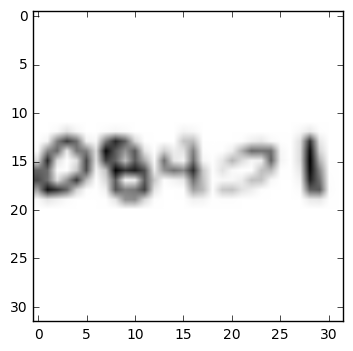

Label : [5 0 8 4 0 1]


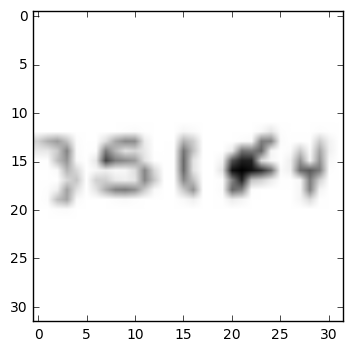

Label : [5 3 5 1 4 4]
After concatenation, sample validation images- 


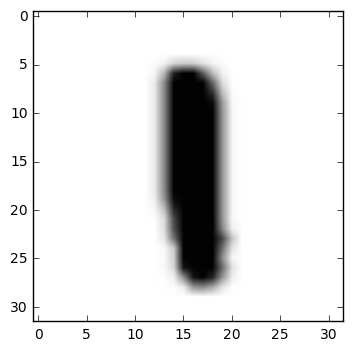

Label : [ 1  1 10 10 10 10]


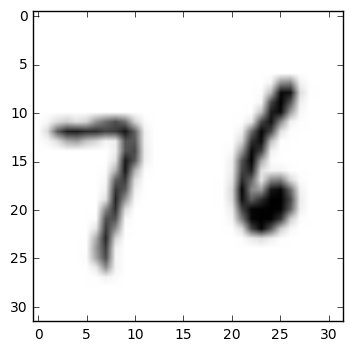

Label : [ 2  7  6 10 10 10]
After concatenation, sample testing images- 


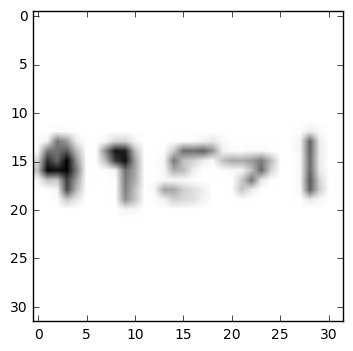

Label : [5 9 9 5 7 1]


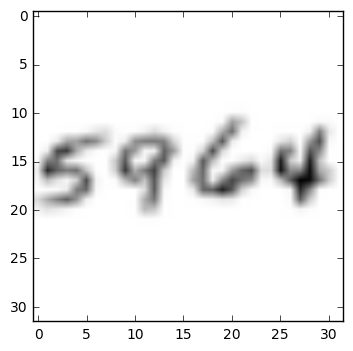

Label : [ 4  5  9  6  4 10]


In [8]:
# display concatenated training, validation and testing sample images

print "After concatenation, sample training images- "
for i in range(0,2):
    rand_num = random.randint(0,train_data.shape[0])
    plt.imshow(train_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(train_labels[rand_num]))
    
print "After concatenation, sample validation images- "
for i in range(0,2):
    rand_num = random.randint(0,validation_data.shape[0])
    plt.imshow(validation_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(validation_labels[rand_num]))
    
print "After concatenation, sample testing images- "
for i in range(0,2):
    rand_num = random.randint(0,test_data.shape[0])
    plt.imshow(test_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(test_labels[rand_num]))

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# import all the required modules

from scipy.ndimage import imread
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy.misc import imresize
import random
import tensorflow as tf

In [2]:
# read the csv files containing info about SVHN data
# the csv files are available at https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader/

train_rows = []
with open('/home/sahil/Downloads/digitStruct_train.csv', 'rb') as csvfile:
    line_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in line_reader:
        temp = row[0].split(",")
        train_rows.append(temp)

train_rows = np.array(train_rows)
train_rows = train_rows[1:,:]

test_rows = []
with open('/home/sahil/Downloads/digitStruct_test.csv', 'rb') as csvfile:
    line_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in line_reader:
        temp = row[0].split(",")
        test_rows.append(temp)

test_rows = np.array(test_rows)
test_rows = test_rows[1:,:]

In [3]:
# preprocess data and generate images and labels

# training data
train_image_filenames = np.unique(train_rows[:,0])

train_data = []
train_labels = []

for x in np.nditer(train_image_filenames):
    curr_image_data = train_rows[np.where(train_rows[:,0] == x)]
    
    image_path = str("/home/sahil/Downloads/street_view_house_numbers/train/") + str(x)
    img = imread(image_path)
    
    
    # turn image into grayscale
    img = np.dot(img[:,:],[0.2989,0.5870,0.1140])
    try:
        img = imresize(img,(32,32))
        mean = np.mean(img)
        std = np.std(img)
        if std < 1e-4:
            std = 1.
        # normalization
        img = (img - mean) / std
        labels = []
        temp = curr_image_data[:,1]
        labels.append(float(temp.shape[0]))
        for i in range(0,temp.shape[0]):
            if float(curr_image_data[i,1]) == float(10):
                labels.append(float(0))
            else:
                labels.append(float(curr_image_data[i,1]))

        if len(labels) < 6:
            while len(labels) < 6:
                labels.append(float(10))

        if len(labels) == 6:
            train_labels.append(tuple(labels))
            train_data.append(img)
    except:
        print "skipping- " + str(x)


train_data = np.array(train_data)
train_labels = np.array(train_labels)

# testing data
test_image_filenames = np.unique(test_rows[:,0])

test_data = []
test_labels = []

for x in np.nditer(test_image_filenames):
    curr_image_data = test_rows[np.where(test_rows[:,0] == x)]
    
    image_path = str("/home/sahil/Downloads/street_view_house_numbers/test/") + str(x)
    img = imread(image_path)
    
    
    # turn image into grayscale
    img = np.dot(img[:,:],[0.2989,0.5870,0.1140])
    try:
        img = imresize(img,(32,32))
        mean = np.mean(img)
        std = np.std(img)
        if std < 1e-4:
            std = 1.
        # normalization
        img = (img - mean) / std
        labels = []
        temp = curr_image_data[:,1]
        labels.append(float(temp.shape[0]))
        for i in range(0,temp.shape[0]):
            if float(curr_image_data[i,1]) == float(10):
                labels.append(float(0))
            else:
                labels.append(float(curr_image_data[i,1]))

        if len(labels) < 6:
            while len(labels) < 6:
                labels.append(float(10))

        if len(labels) == 6:
            test_labels.append(tuple(labels))
            test_data.append(img)
    except:
        print "skipping- " + str(x)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print "Training dataset size- ", train_data.shape, train_labels.shape
print "Testing dataset size- ", test_data.shape, test_labels.shape

Training dataset size-  (33401, 32, 32) (33401, 6)
Testing dataset size-  (13068, 32, 32) (13068, 6)


In [4]:
# split the training data into training and validation datasets

validation_train_split_ratio = 0.2

validation_data_size = int(train_data.shape[0]*validation_train_split_ratio)

validation_data = train_data[0:validation_data_size]
validation_labels = train_labels[0:validation_data_size]

train_data = train_data[validation_data_size:]
train_labels = train_labels[validation_data_size:]

print "Training set size- ", train_data.shape, train_labels.shape
print "Validation set size- ", validation_data.shape, validation_labels.shape
print "Testing set size- ", test_data.shape, test_labels.shape

Training set size-  (26721, 32, 32) (26721, 6)
Validation set size-  (6680, 32, 32) (6680, 6)
Testing set size-  (13068, 32, 32) (13068, 6)


Sample training images- 


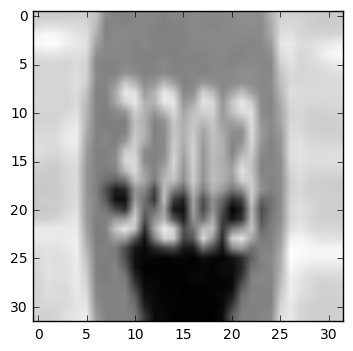

Label : [  4.   3.   2.   0.   3.  10.]


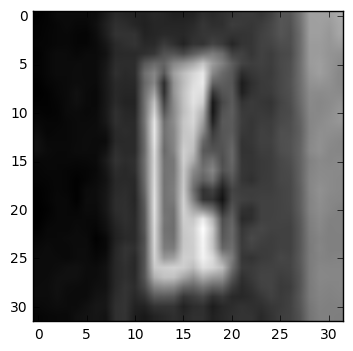

Label : [  2.   1.   4.  10.  10.  10.]
Sample validation images- 


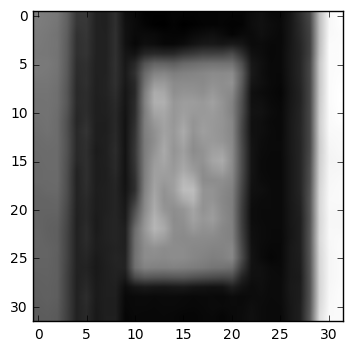

Label : [  2.   2.   9.  10.  10.  10.]


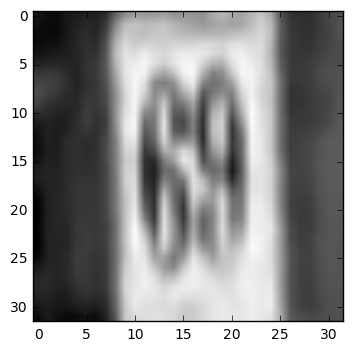

Label : [  2.   6.   9.  10.  10.  10.]
Sample testing images- 


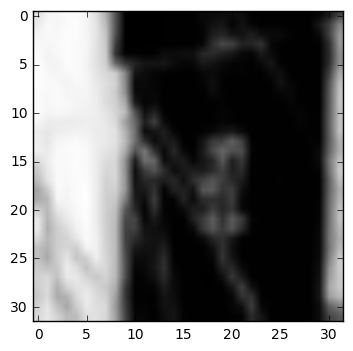

Label : [  2.   9.   2.  10.  10.  10.]


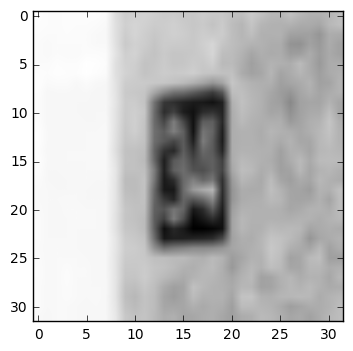

Label : [  2.   3.   4.  10.  10.  10.]


In [5]:
# display concatenated training, validation and testing sample images

print "Sample training images- "
for i in range(0,2):
    rand_num = random.randint(0,train_data.shape[0])
    plt.imshow(train_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(train_labels[rand_num]))
    
print "Sample validation images- "
for i in range(0,2):
    rand_num = random.randint(0,validation_data.shape[0])
    plt.imshow(validation_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(validation_labels[rand_num]))
    
print "Sample testing images- "
for i in range(0,2):
    rand_num = random.randint(0,test_data.shape[0])
    plt.imshow(test_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(test_labels[rand_num]))

In [6]:
# function for formatting data to suit TensorFlow Convolutional Neural Nets

num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, 32, 32, num_channels)).astype(np.float32)
  return dataset

In [7]:
# reformat the data

train_data = reformat(train_data)
validation_data = reformat(validation_data)
test_data = reformat(test_data)

print "Reformatted training dataset size- ", train_data.shape, train_labels.shape
print "Reformatted validation dataset size- ", validation_data.shape, validation_labels.shape
print "Reformatted testing dataset size- ", test_data.shape, test_labels.shape

Reformatted training dataset size-  (26721, 32, 32, 1) (26721, 6)
Reformatted validation dataset size-  (6680, 32, 32, 1) (6680, 6)
Reformatted testing dataset size-  (13068, 32, 32, 1) (13068, 6)


In [8]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [9]:
image_size = 32
num_labels = 11
num_label_columns = 6

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64
#shape = [batch_size, image_size, image_size, num_channels]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_label_columns))
  tf_valid_dataset = tf.constant(validation_data)
  tf_test_dataset = tf.constant(test_data)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(1.0,shape=[depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  
  s1_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s1_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s2_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s2_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s3_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s3_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s4_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s4_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s5_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s5_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
    
  # Model.
  def model(data,keep_prob):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
      
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])

In [10]:
num_steps = 12001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), validation_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 11.832668
Minibatch accuracy: 5.0%
Validation accuracy: 58.6%
Minibatch loss at step 1000: 5.528313
Minibatch accuracy: 62.8%
Validation accuracy: 62.5%
Minibatch loss at step 2000: 4.606456
Minibatch accuracy: 71.9%
Validation accuracy: 68.3%
Minibatch loss at step 3000: 4.438675
Minibatch accuracy: 72.2%
Validation accuracy: 72.3%
Minibatch loss at step 4000: 4.212245
Minibatch accuracy: 75.0%
Validation accuracy: 75.6%
Minibatch loss at step 5000: 3.193830
Minibatch accuracy: 81.2%
Validation accuracy: 77.0%
Minibatch loss at step 6000: 3.048066
Minibatch accuracy: 81.6%
Validation accuracy: 77.9%
Minibatch loss at step 7000: 3.101697
Minibatch accuracy: 82.2%
Validation accuracy: 77.9%
Minibatch loss at step 8000: 2.595182
Minibatch accuracy: 83.8%
Validation accuracy: 78.5%
Minibatch loss at step 9000: 3.189892
Minibatch accuracy: 79.7%
Validation accuracy: 78.9%
Minibatch loss at step 10000: 3.144583
Minibatch accuracy: 83.8%
Validation accur

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** We use the SVHN dataset for training and testing our model on a realistic dataset. Since we are testing out the exact pipeline created for the synthetic MNIST data, we need to preprocess our SVHN dataset for replicating the preprocessing steps performed on the MNIST data. This involved turning the SVHN images into grayscale, re-sizing them to 32-by-32 pixels and normalizing the intensities. Once this was done, we run our pipeline on this data. We achieved 72.6% accuracy with our original pipeline after 12k steps. Clearly, there is room for improvement here.

In [1]:
# import all the required modules

from scipy.ndimage import imread
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy.misc import imresize
import random
import tensorflow as tf

In [2]:
# read the csv files containing info about SVHN data
# the csv files are available at https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader/

train_rows = []
with open('/home/sahil/Downloads/digitStruct_train.csv', 'rb') as csvfile:
    line_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in line_reader:
        temp = row[0].split(",")
        train_rows.append(temp)

train_rows = np.array(train_rows)
train_rows = train_rows[1:,:]

test_rows = []
with open('/home/sahil/Downloads/digitStruct_test.csv', 'rb') as csvfile:
    line_reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in line_reader:
        temp = row[0].split(",")
        test_rows.append(temp)

test_rows = np.array(test_rows)
test_rows = test_rows[1:,:]

In [3]:
# preprocess data and generate images and labels

# training data
train_image_filenames = np.unique(train_rows[:,0])

train_data = []
train_labels = []

for x in np.nditer(train_image_filenames):
    curr_image_data = train_rows[np.where(train_rows[:,0] == x)]
    
    leftmost = int(np.amin(curr_image_data[:,2].astype(np.float)))
    r_element = np.amax(curr_image_data[:,2].astype(np.float))
    r_element_row = curr_image_data[np.where(curr_image_data[:,2].astype(np.float) == r_element)]
    r_width = r_element_row[:,4]
    rightmost = int(r_element) + int(r_width[0])

    topmost = int(np.amin(curr_image_data[:,3].astype(np.float)))
    b_element = np.amax(curr_image_data[:,3].astype(np.float))
    b_element_row = curr_image_data[np.where(curr_image_data[:,3].astype(np.float) == b_element)]
    b_height = b_element_row[:,5]
    bottommost = int(b_element) + int(b_height[0])
    
    image_path = str("/home/sahil/Downloads/street_view_house_numbers/train/") + str(x)
    img = imread(image_path)
    
    # crop image
    img = img[topmost:bottommost, leftmost:rightmost]
    
    # turn image into grayscale
    img = np.dot(img[:,:],[0.2989,0.5870,0.1140])
    try:
        img = imresize(img,(32,32))
        mean = np.mean(img)
        std = np.std(img)
        if std < 1e-4:
            std = 1.
        # normalization
        img = (img - mean) / std
        labels = []
        temp = curr_image_data[:,1]
        labels.append(float(temp.shape[0]))
        for i in range(0,temp.shape[0]):
            if float(curr_image_data[i,1]) == float(10):
                labels.append(float(0))
            else:
                labels.append(float(curr_image_data[i,1]))

        if len(labels) < 6:
            while len(labels) < 6:
                labels.append(float(10))

        if len(labels) == 6:
            train_labels.append(tuple(labels))
            train_data.append(img)
    except:
        print "skipping- " + str(x)


train_data = np.array(train_data)
train_labels = np.array(train_labels)

# testing data
test_image_filenames = np.unique(test_rows[:,0])

test_data = []
test_labels = []

for x in np.nditer(test_image_filenames):
    curr_image_data = test_rows[np.where(test_rows[:,0] == x)]
    
    leftmost = int(np.amin(curr_image_data[:,2].astype(np.float)))
    r_element = np.amax(curr_image_data[:,2].astype(np.float))
    r_element_row = curr_image_data[np.where(curr_image_data[:,2].astype(np.float) == r_element)]
    r_width = r_element_row[:,4]
    rightmost = int(r_element) + int(r_width[0])

    topmost = int(np.amin(curr_image_data[:,3].astype(np.float)))
    b_element = np.amax(curr_image_data[:,3].astype(np.float))
    b_element_row = curr_image_data[np.where(curr_image_data[:,3].astype(np.float) == b_element)]
    b_height = b_element_row[:,5]
    bottommost = int(b_element) + int(b_height[0])
    
    image_path = str("/home/sahil/Downloads/street_view_house_numbers/test/") + str(x)
    img = imread(image_path)
    
    # crop image
    img = img[topmost:bottommost, leftmost:rightmost]
    
    # turn image into grayscale
    img = np.dot(img[:,:],[0.2989,0.5870,0.1140])
    try:
        img = imresize(img,(32,32))
        mean = np.mean(img)
        std = np.std(img)
        if std < 1e-4:
            std = 1.
        # normalization
        img = (img - mean) / std
        labels = []
        temp = curr_image_data[:,1]
        labels.append(float(temp.shape[0]))
        for i in range(0,temp.shape[0]):
            if float(curr_image_data[i,1]) == float(10):
                labels.append(float(0))
            else:
                labels.append(float(curr_image_data[i,1]))

        if len(labels) < 6:
            while len(labels) < 6:
                labels.append(float(10))

        if len(labels) == 6:
            test_labels.append(tuple(labels))
            test_data.append(img)
    except:
        print "skipping- " + str(x)


test_data = np.array(test_data)
test_labels = np.array(test_labels)

print "Training dataset size- ", train_data.shape, train_labels.shape
print "Testing dataset size- ", test_data.shape, test_labels.shape

# newly captured images
newly_captured_data = []

for i in range(1,7):
    img = imread("/home/sahil/Downloads/newly_captured/" + str(i) + ".jpg")
    # turn image into grayscale
    img = np.dot(img[:,:],[0.2989,0.5870,0.1140])
    img = imresize(img,(32,32))
    mean = np.mean(img)
    std = np.std(img)
    if std < 1e-4:
        std = 1.
    # normalization
    img = (img - mean) / std
    newly_captured_data.append(img)

newly_captured_labels = [[3,1,0,0,10,10],[3,8,7,7,10,10],[3,5,2,9,10,10],[4,1,9,3,5,10],[4,2,0,1,6,10],[4,2,1,1,0,10]]

newly_captured_data = np.array(newly_captured_data)
newly_captured_labels = np.array(newly_captured_labels)
print "Newly captured dataset size- ", newly_captured_data.shape, newly_captured_labels.shape

skipping- 11861.png
skipping- 13145.png
skipping- 15125.png
skipping- 18277.png
skipping- 18393.png
skipping- 19383.png
skipping- 20540.png
skipping- 20901.png
skipping- 20915.png
skipping- 22442.png
skipping- 23905.png
skipping- 252.png
skipping- 26570.png
skipping- 27638.png
skipping- 27809.png
skipping- 28513.png
skipping- 28798.png
skipping- 28818.png
skipping- 28850.png
skipping- 29759.png
skipping- 30510.png
skipping- 30953.png
skipping- 3100.png
skipping- 32169.png
skipping- 32432.png
skipping- 5312.png
skipping- 6877.png
skipping- 724.png
skipping- 9357.png
skipping- 12434.png
skipping- 2613.png
skipping- 344.png
skipping- 439.png
skipping- 521.png
skipping- 5260.png
skipping- 7636.png
skipping- 8885.png
Training dataset size-  (33372, 32, 32) (33372, 6)
Testing dataset size-  (13060, 32, 32) (13060, 6)
Newly captured dataset size-  (6, 32, 32) (6, 6)


In [4]:
# split the training data into training and validation datasets

validation_train_split_ratio = 0.2

validation_data_size = int(train_data.shape[0]*validation_train_split_ratio)

validation_data = train_data[0:validation_data_size]
validation_labels = train_labels[0:validation_data_size]

train_data = train_data[validation_data_size:]
train_labels = train_labels[validation_data_size:]

print "Training set size- ", train_data.shape, train_labels.shape
print "Validation set size- ", validation_data.shape, validation_labels.shape
print "Testing set size- ", test_data.shape, test_labels.shape
print "Newly captured set size- ", newly_captured_data.shape, newly_captured_labels.shape

Training set size-  (26698, 32, 32) (26698, 6)
Validation set size-  (6674, 32, 32) (6674, 6)
Testing set size-  (13060, 32, 32) (13060, 6)
Newly captured set size-  (6, 32, 32) (6, 6)


Sample training images- 


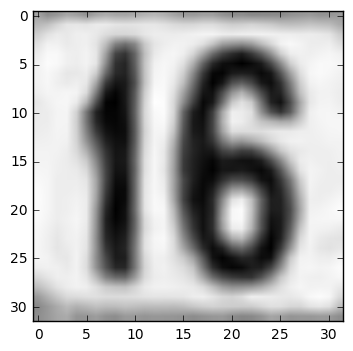

Label : [  2.   1.   6.  10.  10.  10.]


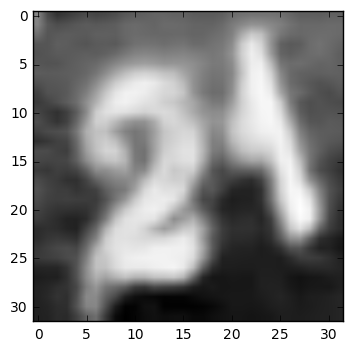

Label : [  2.   2.   1.  10.  10.  10.]
Sample validation images- 


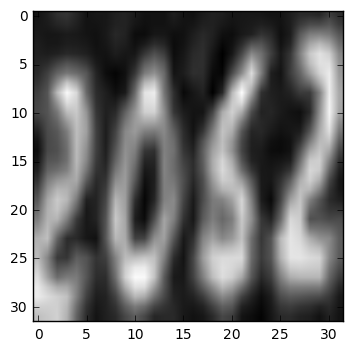

Label : [  4.   2.   0.   6.   2.  10.]


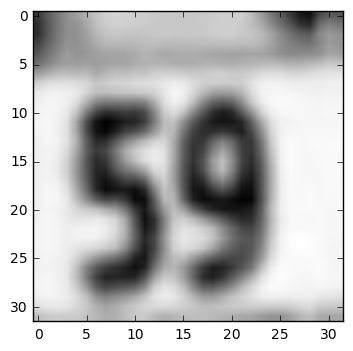

Label : [  2.   5.   9.  10.  10.  10.]
Sample testing images- 


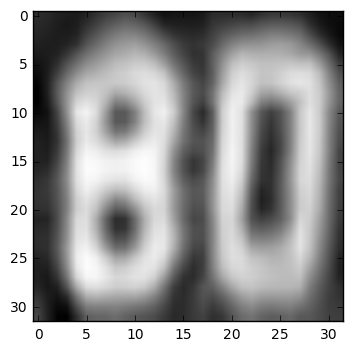

Label : [  2.   8.   0.  10.  10.  10.]


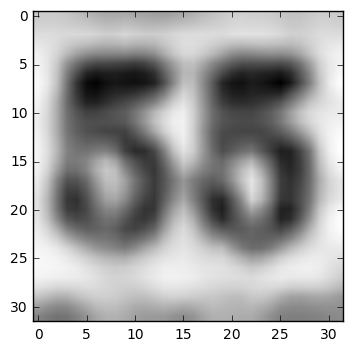

Label : [  2.   5.   5.  10.  10.  10.]


In [5]:
# display concatenated training, validation and testing sample images

print "Sample training images- "
for i in range(0,2):
    rand_num = random.randint(0,train_data.shape[0])
    plt.imshow(train_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(train_labels[rand_num]))
    
print "Sample validation images- "
for i in range(0,2):
    rand_num = random.randint(0,validation_data.shape[0])
    plt.imshow(validation_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(validation_labels[rand_num]))
    
print "Sample testing images- "
for i in range(0,2):
    rand_num = random.randint(0,test_data.shape[0])
    plt.imshow(test_data[rand_num], cmap='Greys')
    plt.show()
    print ('Label : {}'.format(test_labels[rand_num]))

In [6]:
# function for formatting data to suit TensorFlow Convolutional Neural Nets

num_channels = 1

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, 32, 32, num_channels)).astype(np.float32)
  return dataset

In [7]:
# reformat the data

train_data = reformat(train_data)
validation_data = reformat(validation_data)
test_data = reformat(test_data)
newly_captured_data = reformat(newly_captured_data)

print "Reformatted training dataset size- ", train_data.shape, train_labels.shape
print "Reformatted validation dataset size- ", validation_data.shape, validation_labels.shape
print "Reformatted testing dataset size- ", test_data.shape, test_labels.shape
print "Reformatted newly captured dataset size- ", newly_captured_data.shape, newly_captured_labels.shape

Reformatted training dataset size-  (26698, 32, 32, 1) (26698, 6)
Reformatted validation dataset size-  (6674, 32, 32, 1) (6674, 6)
Reformatted testing dataset size-  (13060, 32, 32, 1) (13060, 6)
Reformatted newly captured dataset size-  (6, 32, 32, 1) (6, 6)


In [8]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [9]:
image_size = 32
num_labels = 11
num_label_columns = 6

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden = 64
#shape = [batch_size, image_size, image_size, num_channels]

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_label_columns))
  tf_valid_dataset = tf.constant(validation_data)
  tf_test_dataset = tf.constant(test_data)
  tf_newly_captured_dataset = tf.constant(newly_captured_data)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(1.0,shape=[depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  
  s1_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s1_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s2_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s2_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s3_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s3_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s4_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s4_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
  s5_w = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  s5_b = tf.Variable(tf.constant(1.0,shape=[num_labels]))
    
  # Model.
  def model(data,keep_prob):
    conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer1_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer2_biases)
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID')
    hidden = tf.nn.relu(conv + layer3_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    logits1 = tf.matmul(reshape, s1_w) + s1_b
    logits2 = tf.matmul(reshape, s2_w) + s2_b
    logits3 = tf.matmul(reshape, s3_w) + s3_b
    logits4 = tf.matmul(reshape, s4_w) + s4_b
    logits5 = tf.matmul(reshape, s5_w) + s5_b
    return [logits1, logits2, logits3, logits4, logits5]
      
  # Training computation.
  [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])
  newly_captured_prediction = tf.pack([tf.nn.softmax(model(tf_newly_captured_dataset, 1.0)[0]),\
                     tf.nn.softmax(model(tf_newly_captured_dataset, 1.0)[1]),\
                     tf.nn.softmax(model(tf_newly_captured_dataset, 1.0)[2]),\
                     tf.nn.softmax(model(tf_newly_captured_dataset, 1.0)[3]),\
                     tf.nn.softmax(model(tf_newly_captured_dataset, 1.0)[4])])

In [10]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), validation_labels[:,1:6]))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  print('Newly captured images predictions- ', np.argmax(newly_captured_prediction.eval(), 2).T)
  print('Newly captured accuracy: %.1f%%' % accuracy(newly_captured_prediction.eval(), newly_captured_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 13.412556
Minibatch accuracy: 14.7%
Validation accuracy: 60.4%
Minibatch loss at step 2000: 2.559910
Minibatch accuracy: 86.9%
Validation accuracy: 84.9%
Minibatch loss at step 4000: 1.970201
Minibatch accuracy: 90.3%
Validation accuracy: 88.1%
Minibatch loss at step 6000: 1.339123
Minibatch accuracy: 92.8%
Validation accuracy: 89.0%
Minibatch loss at step 8000: 1.132063
Minibatch accuracy: 95.0%
Validation accuracy: 89.7%
Minibatch loss at step 10000: 1.423754
Minibatch accuracy: 90.6%
Validation accuracy: 89.7%
Minibatch loss at step 12000: 1.159996
Minibatch accuracy: 93.8%
Validation accuracy: 89.8%
Minibatch loss at step 14000: 0.994392
Minibatch accuracy: 94.4%
Validation accuracy: 90.1%
Minibatch loss at step 16000: 1.449815
Minibatch accuracy: 90.9%
Validation accuracy: 89.8%
Minibatch loss at step 18000: 0.744553
Minibatch accuracy: 97.5%
Validation accuracy: 90.0%
Minibatch loss at step 20000: 0.815236
Minibatch accuracy: 96.9%
Validation

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** We included several preprocessing steps described above, reduced the learning rate from 0.05 to 0.03 and increased the number of steps from 12k to 20k. All these changes brought up the accuracy to 90.7%.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** Initial accuracy was about 87% and after tweaking the parameters and preprocessing data, our final accuracy is 90.7%. This indicates our model is doing quite a decent job of classifying digts.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

**Six images were captured, they are displayed in the previous step. They have been preprocessed just like the SVHN dataset.**

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** The images have been displayed in the previous step. There are a couple of images with hyphens included, there are spaces around the digits i.e. not all of them are aligned properly. There are different fonts, colors, intensities etc.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** Our model does reasonably well. The results have been printed in the previous step.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.